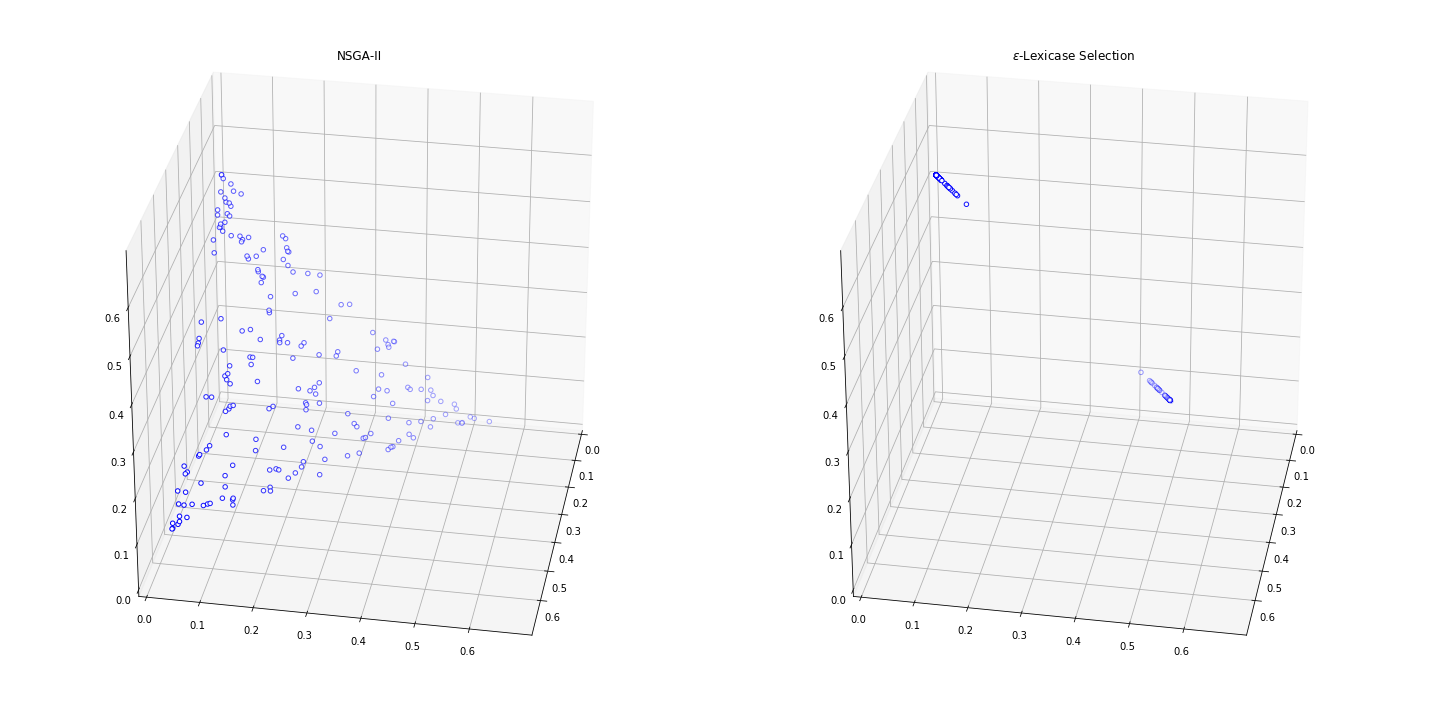

In [54]:
import numpy as np
X = []
g='100'
with open('dtlz1_nsga2.'+g,'r') as f:
	for lines in f:
		if lines !='\n':
			X.append([(float(x)) for x in lines.strip().split(' ')])
Xl = []
with open('dtlz1_lex.'+g,'r') as f:
	for lines in f:
		if lines !='\n':
			Xl.append([(float(x)) for x in lines.strip().split(' ')])
            
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 
a = 30
b = 10
lim = 0.7
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
X = np.array(X)
ax.scatter(X[:,0],X[:,1],X[:,2],color=None,facecolor='w',edgecolors='b')
ax.set_xlim(0,lim)
ax.set_ylim(0,lim)
ax.set_zlim(0,lim)
ax.view_init(a, b)
ax.set_title('NSGA-II')
#fig2 = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot(122, projection='3d')
Xl = np.array(Xl)
ax2.scatter(Xl[:,0],Xl[:,1],Xl[:,2],color=None,facecolor='w',edgecolors='b')
ax2.set_xlim(0,lim)
ax2.set_ylim(0,lim)
ax2.set_zlim(0,lim)
ax2.set_title('$\epsilon$-Lexicase Selection')
ax2.view_init(a,b)
fig.tight_layout()
fig.savefig('dtlz1_m3_nsga_lex_comparison.pdf')
plt.show()
